This notebook: can we use the outputs of `to_cdr` to reproduce the epoched data / ERP results from the control?

In [9]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [12]:
# CDR_OUTPUT_DIR = Path("../work/c0/e17e6385700b9d22bdfce8b5d25eb5")
# CDR_X = CDR_OUTPUT_DIR / "X.txt"
# CDR_Y = CDR_OUTPUT_DIR / "y.txt"
# DATASET_SPLIT_TARGET = None
# UNIVARIATE_RESPONSE = False

# Subset fit data
# CDR_OUTPUT_DIR = Path("../work/0d/1c849c11642f62c70766b725592872")
CDR_OUTPUT_DIR = Path("../work/21/fefac160ec95f6f4c926d94be2f225")
CDR_X = CDR_OUTPUT_DIR / "X_subset.txt"
CDR_Y = CDR_OUTPUT_DIR / "y_subset.train.txt"
DATASET_SPLIT_TARGET = "train"
UNIVARIATE_RESPONSE = True

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = [f"el{x}" for x in ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]]

In [13]:
X = pd.read_csv(CDR_X, sep=" ", index_col="index")

In [14]:
more = []
for (subject, item, word_idx), rows in X.groupby(["subject", "item", "word_idx"]):
    if len(rows) > 1:
        more.append(((subject, item, word_idx), rows))

In [15]:
more

# TODO work this out ..

[]

In [16]:
y = pd.read_csv(CDR_Y, sep=" ", index_col=None).set_index(["subject", "item"])

In [17]:
# Zero out clock at the start of each item.
item_times = pd.DataFrame(X.groupby(["subject", "item"]).time.min())
item_times["y_time"] = y.groupby(["subject", "item"]).time.min()
item_times["min_time"] = item_times.fillna(0.0).min(axis=1)
X.time -= X.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time
y.time -= y.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time

In [18]:
X

,subject,onset_time,word_idx,sentence_idx,subject_idx,presentation_idx,index.1,word,surprisal,word_len,word_freq,artifact,item,time,modulus,target
index,,,,,,,,,,,,,,,,
27,1,36.096,1,203,1,126.0,1892.0,by,10.882710,2.0,-5.218100,0.0,203,0.784,0,train
28,1,36.752,2,203,1,126.0,1893.0,one,2.779325,3.0,-5.972567,0.0,203,1.440,0,train
29,1,37.436,3,203,1,126.0,1894.0,she,8.529337,3.0,-5.744995,0.0,203,2.124,0,train
30,1,38.120,4,203,1,126.0,1895.0,placed,8.985992,6.0,-9.322938,0.0,203,2.808,0,train
31,1,38.864,5,203,1,126.0,1896.0,her,2.421367,3.0,-5.759478,0.0,203,3.552,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,24,1918.460,7,181,24,55.0,1611.0,toilet,16.204191,6.0,-11.321478,0.0,181,4.980,1,train
2048,24,1919.200,8,181,24,55.0,1612.0,looking,8.489117,7.0,-8.381814,0.0,181,5.720,1,train
2049,24,1919.972,9,181,24,55.0,1613.0,a,5.442509,1.0,-3.840815,0.0,181,6.492,1,train


In [19]:
y

run_sample_id   time     VEOG     HEOG      50       36      49  \
subject item                                                                    
1       203            8828  0.000  -1.6591   5.4803 -1.6918   5.6932 -3.5264   
        203            8829  0.004  -2.2615   6.3308 -1.9342   4.7312 -3.6473   
        203            8830  0.008  -2.2604   7.3026 -1.8114   4.1304 -3.4023   
        203            8831  0.012  -2.1977   8.4574 -1.2616   3.9523 -2.6079   
        203            8832  0.016  -2.0731   9.5527 -0.4064   4.1973 -1.6297   
...                     ...    ...      ...      ...     ...      ...     ...   
24      181          480565  8.780  25.8983  16.4171 -4.4915   0.0603  3.6250   
        181          480566  8.784  31.1419  14.5300 -1.9993  -3.0645  4.7439   
        181          480567  8.788  35.4561  12.8264 -0.5733  -7.1244  5.2970   
        181          480568  8.792  37.6126  11.3066 -1.0893 -11.3752  5.0339   
        181          480569  8.796  36.6981  10.2857 -3.3574 -14.8819  4.0190   

                   37       48      38  ...       22      18       10  \
subject item                            ...                             
1       203    0.6095   1.3421  4.1761  ...   4.1655  3.0536  11.0338   
        203   -0.4954   1.4670  2.8237  ...   3.1869  3.4188  10.4300   
        203   -0.8630   1.8396  1.8405  ...   2.3309  3.9054   9.7053   
        203   -0.5545   2.3978  1.1649  ...   1.9037  4.2108   9.0422   
        203    0.4303   3.2655  1.0434  ...   1.5385  4.6995   8.4410   
...               ...      ...     ...  ...      ...     ...      ...   
24      181   15.6397  17.6590  8.1937  ...  -5.2063  9.6908   0.0445   
        181   13.7477  16.4001  6.3020  ...  -7.2220  8.6760  -1.3445   
        181    9.5197  14.5718  3.9688  ...  -8.6733  6.8478  -2.8005   
        181    3.4611  12.6828  1.0683  ...  -9.6856  4.2063  -4.6955   
        181   -3.1024  11.0482 -1.8320  ... -10.1951  1.3159  -6.5903   

                   16       12       35        8  mean_response  modulus  \
subject item                                                               
1       203   -3.5169  10.2182   4.7512   1.9613        10.7431        0   
        203   -3.3968   7.5479   3.9032   1.9624         8.9684        0   
        203   -3.3957   4.6348   3.4191   1.9635         7.3633        0   
        203   -3.2139   2.0262   3.2392   2.0262         6.2568        0   
        203   -2.8511   0.2080   3.4851   2.1508         5.8644        0   
...               ...      ...      ...      ...            ...      ...   
24      181   13.4847  21.2778  15.9267  17.9132        13.4235        1   
        181   11.4928  19.5154  12.7995  16.4001        12.4653        1   
        181    9.0661  16.9395   6.3774  14.5718        11.1660        1   
        181    6.5639  13.4256  -2.3461  12.4287         9.4849        1   
        181    4.5406   9.5381 -11.4418  10.2857         7.7978        1   

              target  
subject item          
1       203    train  
        203    train  
        203    train  
        203    train  
        203    train  
...              ...  
24      181    train  
        181    train  
        181    train  
        181    train  
        181    train  

[1258057 rows x 27 columns]

---

In [22]:
epoch_data = []

X_tgt = X
if DATASET_SPLIT_TARGET is not None:
    X_tgt = X_tgt[X_tgt.target == DATASET_SPLIT_TARGET]
grouper = X_tgt.groupby(["subject", "item", "word_idx"])
for (subject, item, word_idx), rows in tqdm(grouper, total=grouper.ngroups):
    # TODO should always be 1 row.
    if len(rows) > 1:
        print(f"Warning: {len(rows)} rows for {(subject, item, word_idx)}.")
    x = rows.iloc[0]
    
    try:
        y_df = y.loc[subject].loc[item]
    except KeyError:
        # Response df is a train split of a larger dataset. Missing data is fine.
        pass
    
    epoch_left, epoch_right = EPOCH_WINDOW
    epoch_window = y_df[(y_df.time >= x.time + epoch_left) & (y_df.time <= x.time + epoch_right)]
    
    baseline_window = epoch_window[epoch_window.time <= x.time]
    
    test_left, test_right = TEST_WINDOW
    test_window = epoch_window[(epoch_window.time >= x.time + test_left) & (epoch_window.time <= x.time + test_right)]
    
    if UNIVARIATE_RESPONSE:
        baseline_window = baseline_window.mean_response
        test_window = test_window.mean_response
    else:
        # subset electrodes
        baseline_window = baseline_window[N400_ELECTRODES]
        test_window = test_window[N400_ELECTRODES]
    
    # take means
    baseline_window = baseline_window.mean(axis=0)
    test_window = test_window.mean(axis=0)
    
    if not UNIVARIATE_RESPONSE:
        # Avg over electrodes
        baseline_window = baseline_window.mean()
        test_window = test_window.mean()
    
    epoch_data.append((subject, item, x.word_idx, baseline_window, test_window))

  0%|          | 0/6170 [00:00<?, ?it/s]

In [33]:
epoch_df = pd.DataFrame(epoch_data, columns=["subject_idx", "sentence_idx", "word_idx", "cdr_base_N400", "cdr_value_N400"]) \
    .set_index(["subject_idx", "sentence_idx", "word_idx"]) \
    .dropna()
epoch_df

cdr_base_N400  cdr_value_N400
subject_idx sentence_idx word_idx                               
1           12           1             -7.410932      -10.019828
                         2             -6.046940       -6.533838
                         3            -12.377544       -6.223930
                         4             -4.894736       -9.425676
                         5             -6.768932        3.510020
...                                          ...             ...
24          201          10           -13.790652       -2.486372
                         11            -5.740632       -2.130230
                         12            -0.762888       -9.020166
                         13            -5.081200        3.211666
                         14           -10.146316       12.812446

[5320 rows x 2 columns]

-----

In [24]:
REFERENCE_DATASET = Path("../output/frank2015/erp/erp_full.csv")
reference_df = pd.read_csv(REFERENCE_DATASET, index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  ...  \
subject_idx sentence_idx word_idx                                    ...   
1           1            0                3.145689         3.121044  ...   
                         1                8.214565         7.030273  ...   
                         2                8.330564         6.914139  ...   
                         3                3.210452         2.787990  ...   
                         4                8.541803         8.242652  ...   
...                                            ...              ...  ...   
24          205          7                3.924689         3.901125  ...   
                         8                7.945024         6.722867  ...   
                         9                9.959173         8.835783  ...   
                         10               3.884360         3.874658  ...   
                         11               8.574935         8.116138  ...   

                                   surp_rnn_size_6  surp_rnn_size_

---

## Compare with pre-packaged ERP data

From Frank et al 2015 dataset

In [35]:
comp_df = pd.merge(epoch_df, reference_df, how="left", left_index=True, right_index=True)
comp_df

cdr_base_N400  cdr_value_N400  value_N400  \
subject_idx sentence_idx word_idx                                              
1           12           1             -7.410932      -10.019828   -3.102596   
                         2             -6.046940       -6.533838    0.724958   
                         3            -12.377544       -6.223930    0.131685   
                         4             -4.894736       -9.425676   -4.246184   
                         5             -6.768932        3.510020    8.167854   
...                                          ...             ...         ...   
24          201          10           -13.790652       -2.486372    3.075519   
                         11            -5.740632       -2.130230    2.134300   
                         12            -0.762888       -9.020166   -6.477233   
                         13            -5.081200        3.211666    3.296071   
                         14           -10.146316       12.812446   11.546489   

                                   base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                
1           12           1         -0.840925         0       0   
                         2          0.951750         0       0   
                         3         -5.029632         0       0   
                         4          1.152589         0       0   
                         5         -1.746493         0       1   
...                                      ...       ...     ...   
24          201          10        -8.640387         0       0   
                         11        -0.018254         0       0   
                         12         3.136234         0       0   
                         13        -3.932482         0       0   
                         14       -10.922804         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           12           1                   4.802778            4.024850   
                         2                   3.310956            3.375475   
                         3                   2.174838            1.141663   
                         4                   2.348038            1.610039   
                         5                   5.491619            4.883691   
...                                               ...                 ...   
24          201          10                  6.511872            6.649267   
                         11                  2.427731            1.174747   
                         12                  7.004234            6.183086   
                         13                  1.177717            0.190081   
                         14                  7.128182            0.455263   

                                   surp_ngram_order_4  surp_rnn_size_1  ...  \
subject_idx sentence_idx word_idx                                       ...   
1           12           1                   3.964338         9.687713  ...   
                         2                   3.376465         7.451422  ...   
                         3                   1.085190         2.118250  ...   
                         4                   0.954647         1.749637  ...   
                         5                   4.542287         9.845520  ...   
...                                               ...              ...  ...   
24          201          10                  6.762439         5.838901  ...   
                         11                  1.161330         2.426839  ...   
                         12                  3.670136         9.128232  ...   
                         13                  0.211060         0.719603  ...   
                         14                  0.484185        11.050338  ...   

                                   surp_rnn_size_6  surp_rnn_size_7  \
subject_idx sentence_idx word_idx 

<AxesSubplot:xlabel='cdr_value_N400', ylabel='value_N400'>

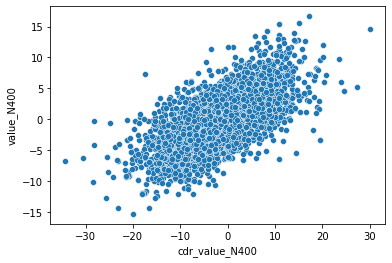

In [36]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="value_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='base_N400'>

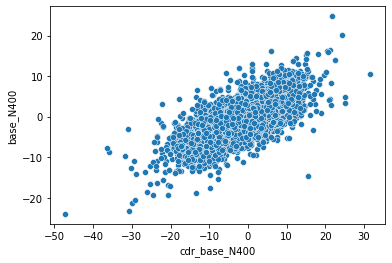

In [37]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="base_N400")

In [38]:
import scipy.stats

In [39]:
scipy.stats.pearsonr(comp_df.value_N400, comp_df.cdr_value_N400)

(0.6523649385717023, 0.0)

In [40]:
scipy.stats.pearsonr(comp_df.base_N400, comp_df.cdr_base_N400)

(0.7010449696490713, 0.0)

Just as before, it's not a perfect correlation -- there is preprocessing done in Frank et al., e.g. the modulus transformation, not done in our pipeline -- but things look pretty good.

---

## Compare with our own MNE-based ERP data

<AxesSubplot:xlabel='cdr_value_N400', ylabel='our_N400'>

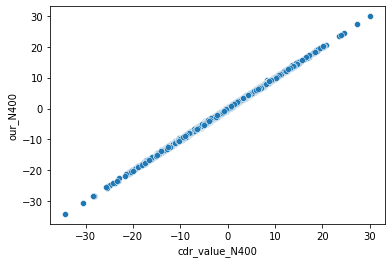

In [41]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="our_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='our_baseline'>

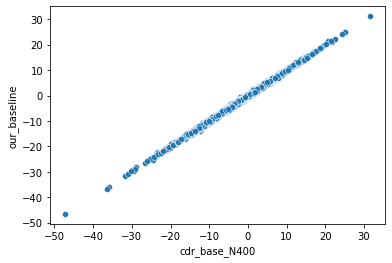

In [42]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="our_baseline")

In [43]:
scipy.stats.pearsonr(comp_df.cdr_value_N400, comp_df.our_N400)

(0.9998073999308855, 0.0)

In [44]:
scipy.stats.pearsonr(comp_df.cdr_base_N400, comp_df.our_baseline)

(0.999391629903717, 0.0)

Perfect.